<a href="https://colab.research.google.com/github/RyanChen12035/w266_final_Anatomy-and-Structured-Prunning/blob/main/anatomy_gradient_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# model is not in training
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [19]:
# Example input
text = ["This is possibly the worst movie ever made, with no redeeming qualities whatsoever."]
inputs = tokenizer.encode(text, return_tensors="pt") #only output input_ids



# forward pass, outputting all hidden states
outputs = model(inputs, output_hidden_states=True)
last_hidden_state = outputs.last_hidden_state
all_hidden_states = outputs.hidden_states
print(last_hidden_state.shape)
print(len(all_hidden_states))
# (examples, sequence, embedding dimensions)
# 12 layers + the initial embedding after positional embedded

input_representations = all_hidden_states[0]  #input for the first layer of transformer
input_representations.retain_grad()   # make sure the tensor is in the graph and ready for gradient calculation

# input_representations.clone().detach().requires_grad_(True) even though it can create a new tensor and put it into the graph, but not the original graph. you have to create a new graph for pytorch.
# .clone() creates a copy of the tensor so that the original input_ids tensor is not modified
# .detach() returns a new tensor, detached from the current computation graph.
# .reguires_grad_(True) enable the gradient calculation again


cls_last = last_hidden_state[:, 0, :] # cls token of the last layer of transformer, #shape of 1, 768
cls_last_loss = cls_last.sum() # asumming loss (scalar) for the input. Not for training but for calculating gradients

#calculate gradient with respect to the input_representations (tensor inside the graph) and save it to the attribute .grad of the tensor input_representations
cls_last_loss.backward() # scalar with respect to the tensor inside the graph. Calculate the gradient of tensor and save the gradient to the attribute .grad of tensors.

input_representations_grad = input_representations.grad
print("input_representations shape: ", input_representations_grad.shape)

torch.Size([1, 19, 768])
13
input_representations shape:  torch.Size([1, 19, 768])


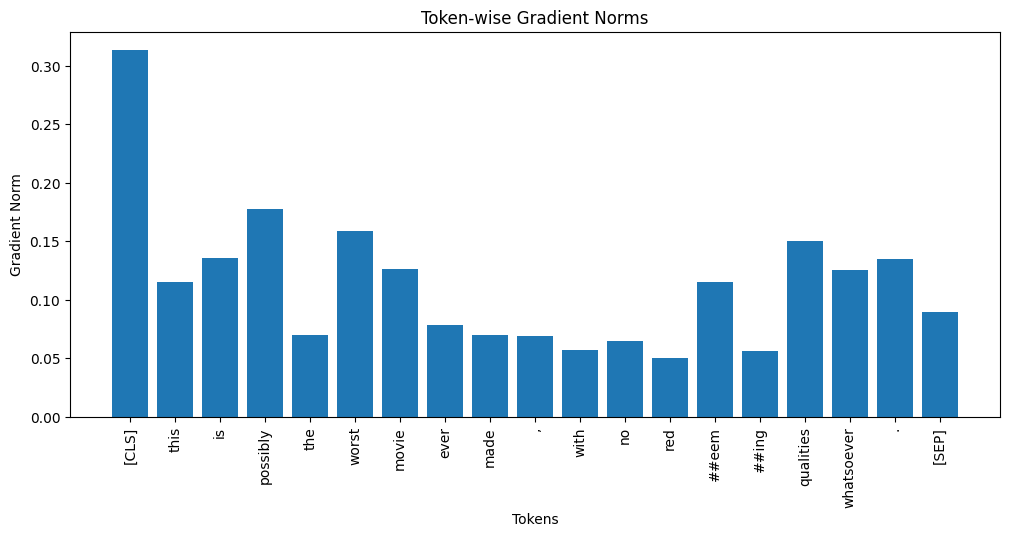

In [21]:
import matplotlib.pyplot as plt

# Calculate the norm of gradients for each token to see their impact
gradient_norms = input_representations_grad.norm(dim=2).squeeze()

# Convert input_ids directly for token conversion (correcting the earlier mistake)
tokens = tokenizer.convert_ids_to_tokens(inputs.squeeze().tolist())
plt.figure(figsize=(12, 5))
plt.bar(tokens, gradient_norms.detach().numpy())
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Gradient Norm')
plt.title('Token-wise Gradient Norms')
plt.show()

In [29]:
input_representations.clone().detach().numpy()[:,0,:][0].shape

(768,)

[ 72 168 283 308 345 387 429 487 541 650 654 751]


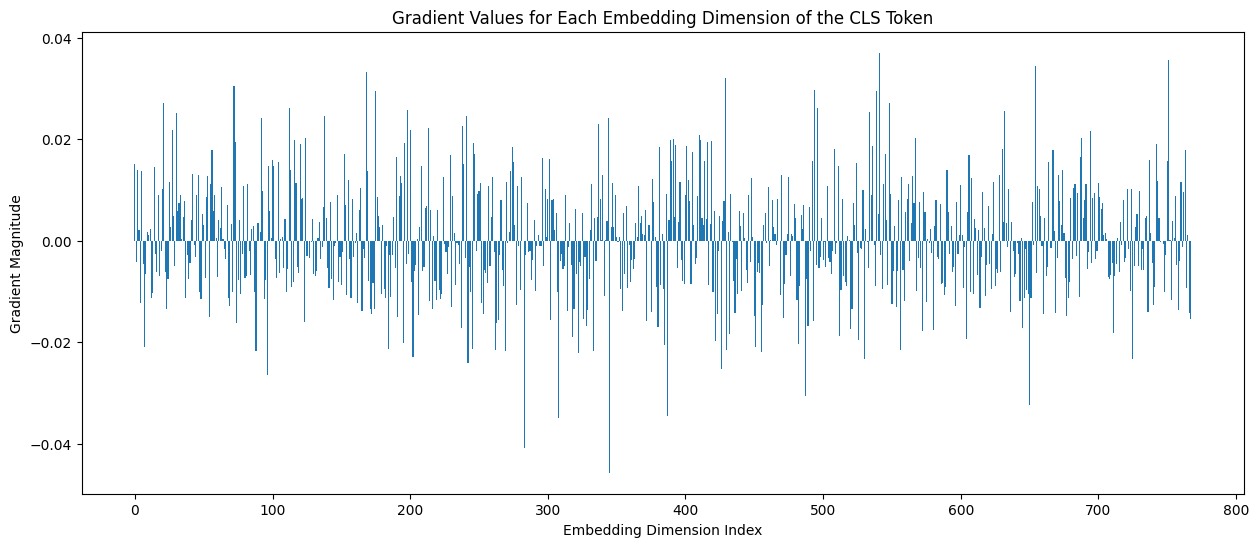

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming input_representations_grad contains the gradients of the input embeddings
cls_token_gradients = input_representations_grad[:, 0, :].clone().detach().numpy()[0]  # Extract gradients for the CLS token
print(np.where(abs(cls_token_gradients) > 0.03)[0])


# Plotting
plt.figure(figsize=(15, 6))
plt.bar(range(len(cls_token_gradients)), cls_token_gradients)
plt.title('Gradient Values for Each Embedding Dimension of the CLS Token')
plt.xlabel('Embedding Dimension Index')
plt.ylabel('Gradient Magnitude')
plt.show()

In [53]:
# Per layer of transformer and per token position
# The gradients captured are the partial derivatives of the sum of the last cls tokeb with respect to the output of each layer.

text = "This is possibly the worst movie ever made, with no redeeming qualities whatsoever."
inputs = tokenizer.encode(text, return_tensors="pt")
outputs = model(inputs, output_hidden_states=True)

# Function to apply hooks
gradients = {}
def save_grad(layer):
    def hook(grad_output):
        gradients[layer] = grad_output[0].clone().detach().numpy()
        return None
    return hook

# Apply hooks to all layers
for i, layer in enumerate(model.encoder.layer):
    layer.register_full_backward_hook(save_grad(f'Layer {i+1}'))

# Calculate gradients
output = outputs.last_hidden_state.sum()
output.backward()
print(gradients['Layer 1'].shape)
gradients

(1, 19, 768)


{'Layer 12': array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 'Layer 11': array([[[ 0.04192898, -0.05867101, -0.02711834, ...,  0.01081981,
           0.07069866,  0.04982673],
         [ 0.08909401, -0.06570576, -0.05948969, ...,  0.00644641,
          -0.00967759,  0.03656858],
         [ 0.07841572, -0.04492266, -0.02716508, ...,  0.07522427,
           0.01637661, -0.02239384],
         ...,
         [ 0.03064216, -0.02927834, -0.0503856 , ...,  0.05863985,
          -0.01331401,  0.022519  ],
         [ 0.26056436, -0.60556483, -0.2846793 , ...,  1.2507374 ,
           1.1529288 ,  0.68614936],
         [ 0.23319687, -0.12046719, -0.15061165, ...,  0.01944286,
           0.09175026,  0.0091117 ]]], dtype=float32),
 'Layer 10': array([[[ 4.0908981e-02, -1.5821931

In [94]:
output

tensor(-184.5609, grad_fn=<SumBackward0>)

In [86]:
print(np.where(abs(gradients['Layer 11'][:, 0, :][0]) > 0.2)[0])

[ 46  52 103 132 197 206 267 273 308 381 396 423]


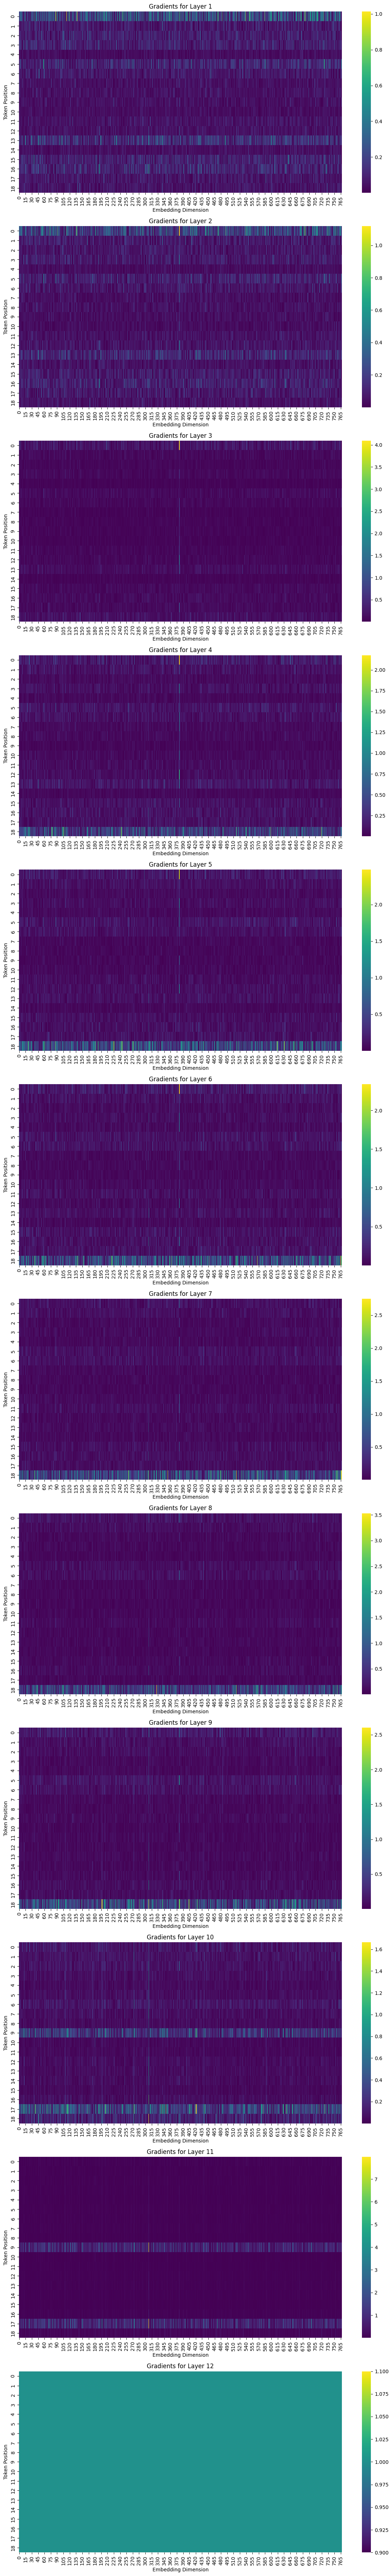

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'gradients' is your dictionary with layer keys and gradient tensors
# Example: visualize the first two layers for simplicity
layers_to_visualize = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9', 'Layer 10', 'Layer 11', 'Layer 12']

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))  # Adjust size as needed


# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    # Get the gradient tensor for the layer, remove batch dimension assuming batch size is 1
    gradient_matrix = gradients[layer].squeeze(0)

    # Plot heatmap
    sns.heatmap(abs(gradient_matrix), ax=ax, cmap='viridis', cbar=True)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

# Show the plot
plt.tight_layout()
plt.show()

# how changes in each dimension of the CLS token's embeddings (from the target layer) would affect the summed scalar value derived from the CLS token's final output (last hidden state).
# High absolute values in this gradient suggest that modifications to those dimensions would have a larger impact on the model's output, making those dimensions particularly influential or sensitive.
# the gradients for each layer represent the sensitivity of the loss (last cls token) with respect to that layer's outputs

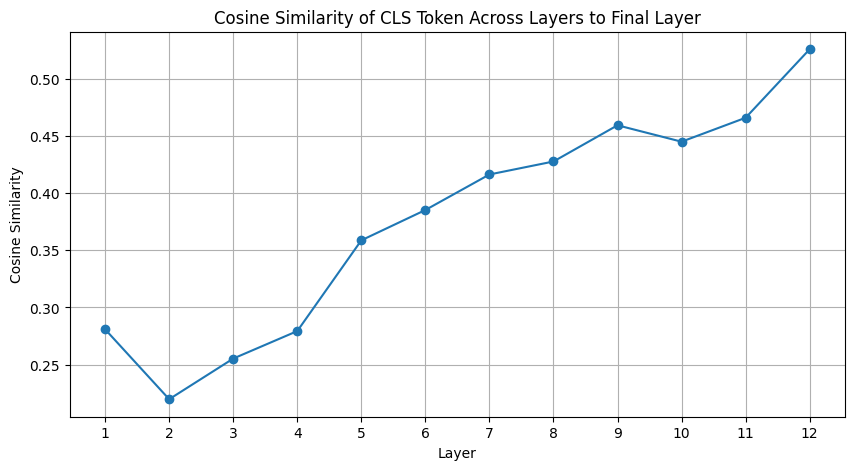

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Example input
text = "This is possibly the worst movie ever made, with no redeeming qualities whatsoever."
inputs = tokenizer.encode(text, return_tensors="pt") #only output input_ids

# forward pass, outputting all hidden states
outputs = model(inputs, output_hidden_states=True)
last_hidden_state = outputs.last_hidden_state
hidden_states = outputs.hidden_states


# Assuming hidden_states is obtained from the model outputs
cls_similarities = []

# Extract the CLS token from the last layer for comparison
final_cls = hidden_states[-1][:, 0, :]  # Last layer, first token

for i in range(len(hidden_states) - 1):  # Exclude the last layer as it is used for comparison
    current_cls = hidden_states[i][:, 0, :]  # First token of each layer
    # Compute cosine similarity and take the mean across the batch if needed
    cosine_sim = F.cosine_similarity(current_cls, final_cls, dim=1).mean().item()
    cls_similarities.append(cosine_sim)

# Plot the cosine similarities between the CLS token of each layer and the last layer's CLS token
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(hidden_states)), cls_similarities, marker='o', linestyle='-')
plt.title('Cosine Similarity of CLS Token Across Layers to Final Layer')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.xticks(range(1, len(hidden_states)))  # Adjust the x-ticks to match layer numbers
plt.grid(True)
plt.show()


In [ ]:
# it's the data vs model. average the gradient of the first 100 example with respect to BERT, Llama2...
# I am expecting something like, the data are focus on strengthening the first three token position of BERT and embedding dimension x,y,z...
# do peft and reft on these layers and token positions.

In [2]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [3]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [21]:
texts = [text.decode('utf-8') for text in train_examples[:32].numpy()]
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

outputs = model(**inputs, output_hidden_states=True)
last_hidden_state = outputs.last_hidden_state
all_hidden_states = outputs.hidden_states

# Function to apply hooks
gradients = {}
def save_grad(layer):
    def hook(module, grad_input, grad_output):
        gradients[layer] = grad_output[0].mean(dim=0).clone().detach().numpy()
        return None
    return hook

# Apply hooks to all layers
for i, layer in enumerate(model.encoder.layer):
    layer.register_full_backward_hook(save_grad(f'Layer {i+1}'))

# Calculate gradients
# get the cls token
cls_last = last_hidden_state[:, 0, :] # shape of 32, 768
output = cls_last.mean(dim=0).sum() # average all examples and sum up as a scalar
output.backward()
print(gradients['Layer 1'].shape)
gradients

(128, 768)


{'Layer 12': array([[0.03125, 0.03125, 0.03125, ..., 0.03125, 0.03125, 0.03125],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        ...,
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]],
       dtype=float32),
 'Layer 11': array([[ 6.47118723e-04, -5.56851621e-04,  1.23360194e-03, ...,
          6.70882291e-05, -1.15481234e-04, -2.46956886e-04],
        [-1.33275116e-05,  1.13077476e-06, -1.81489595e-05, ...,
          1.27357384e-06,  2.29257948e-05,  1.90636947e-05],
        [-9.90547869e-06,  3.12756583e-07, -8.74324178e-06, ...,
          6.91988043e-06,  1.34532875e-05,  2.01746880e-05],
        ...,
        [ 5.85893122e-06, -2.69336124e-05, -2.14252632e-05, ...,
         -1.69348914e-06,  1.84597102e-05,  9.67411415e-06],
        

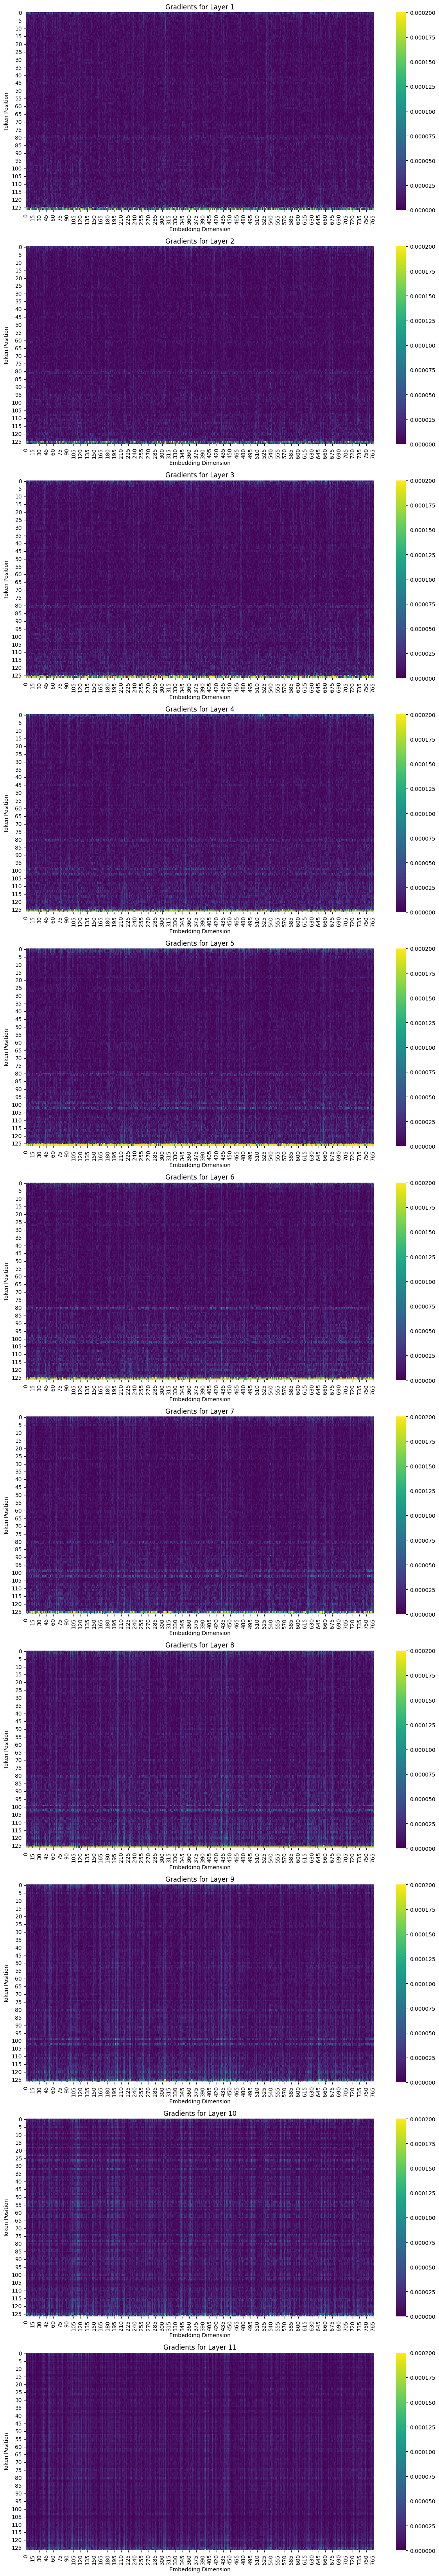

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

layers_to_visualize = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9', 'Layer 10', 'Layer 11']

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))  # Adjust size as needed

# Define the colorbar range
vmin = 0  # Minimum value of the gradient magnitude to display
vmax = 0.0002  # Maximum value of the gradient magnitude to display

# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    gradient_matrix = gradients[layer]

    first_20_tokens = gradient_matrix[1:, :] # exclude cls
    # Plot heatmap
    sns.heatmap(abs(first_20_tokens), ax=ax, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

    # ax.set_yticks(np.arange(20))  # Set y-ticks to show each token position
    # ax.set_yticklabels(np.arange(1, 21))  # Label from 1 to 20 for clarity

# Show the plot
plt.tight_layout()
plt.show()

# plot only first 20 token postions

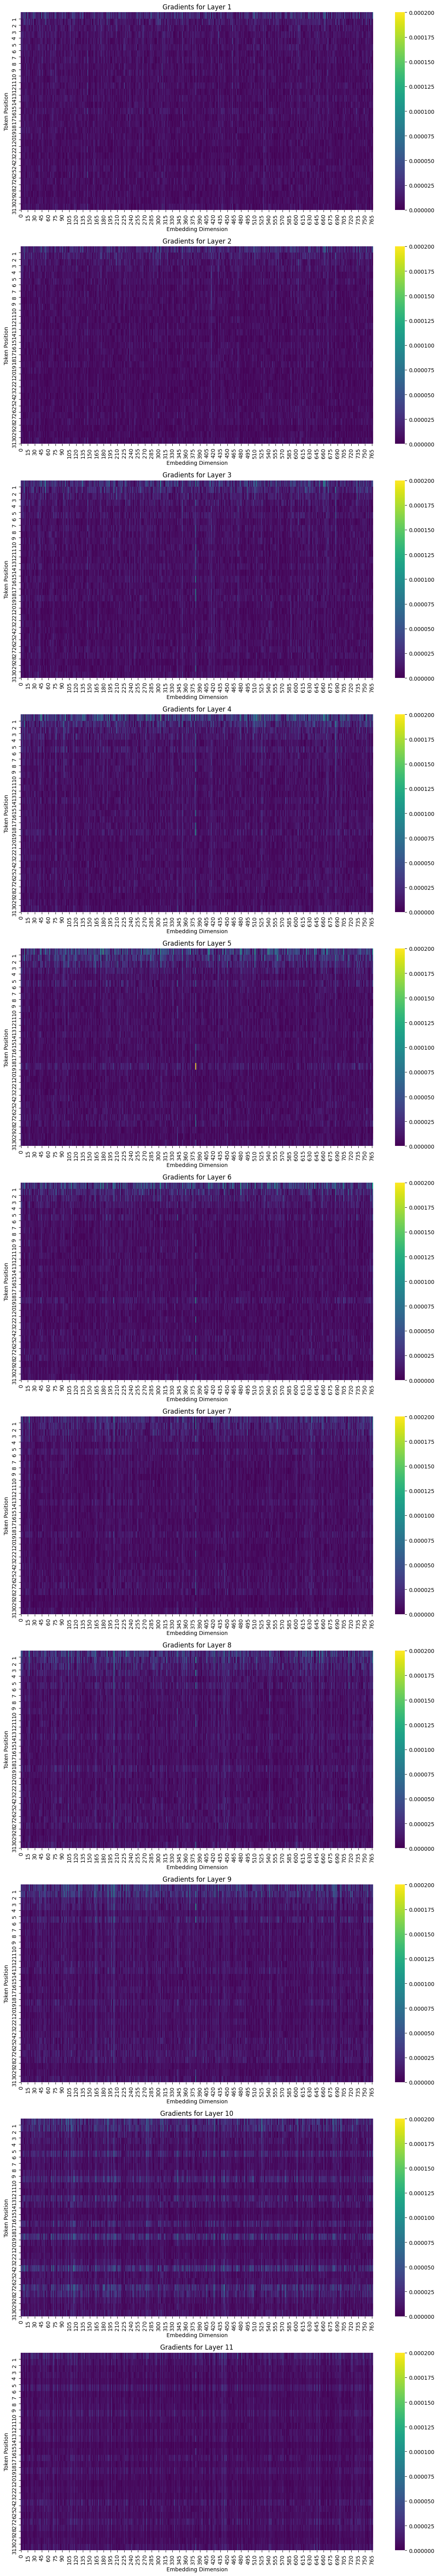

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

layers_to_visualize = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9', 'Layer 10', 'Layer 11']

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))  # Adjust size as needed

# Define the colorbar range
vmin = 0  # Minimum value of the gradient magnitude to display
vmax = 0.0002  # Maximum value of the gradient magnitude to display

# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    gradient_matrix = gradients[layer]

    first_20_tokens = gradient_matrix[1:32, :] # exclude cls
    # Plot heatmap
    sns.heatmap(abs(first_20_tokens), ax=ax, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

    ax.set_yticks(np.arange(1, 32))
    ax.set_yticklabels(np.arange(1, 32))

# Show the plot
plt.tight_layout()
plt.show()

# plot only first 20 token postions

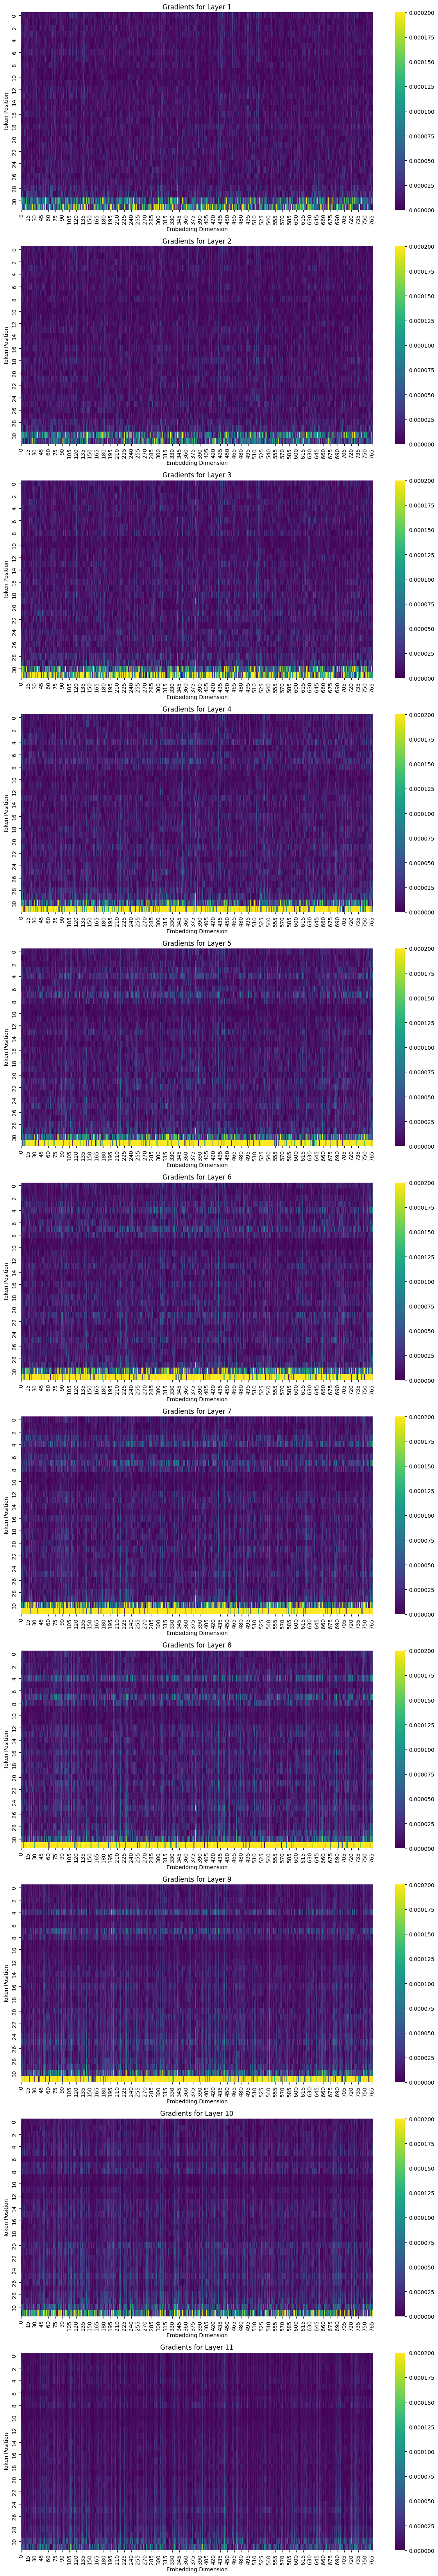

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

layers_to_visualize = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9', 'Layer 10', 'Layer 11']

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))  # Adjust size as needed

# Define the colorbar range
vmin = 0  # Minimum value of the gradient magnitude to display
vmax = 0.0002  # Maximum value of the gradient magnitude to display

# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    gradient_matrix = gradients[layer]

    first_20_tokens = gradient_matrix[96:128, :] # exclude cls
    # Plot heatmap
    sns.heatmap(abs(first_20_tokens), ax=ax, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

    # ax.set_yticks(np.arange(96, 128))
    # ax.set_yticklabels(np.arange(96, 128))

# Show the plot
plt.tight_layout()
plt.show()

# plot only first 20 token postions

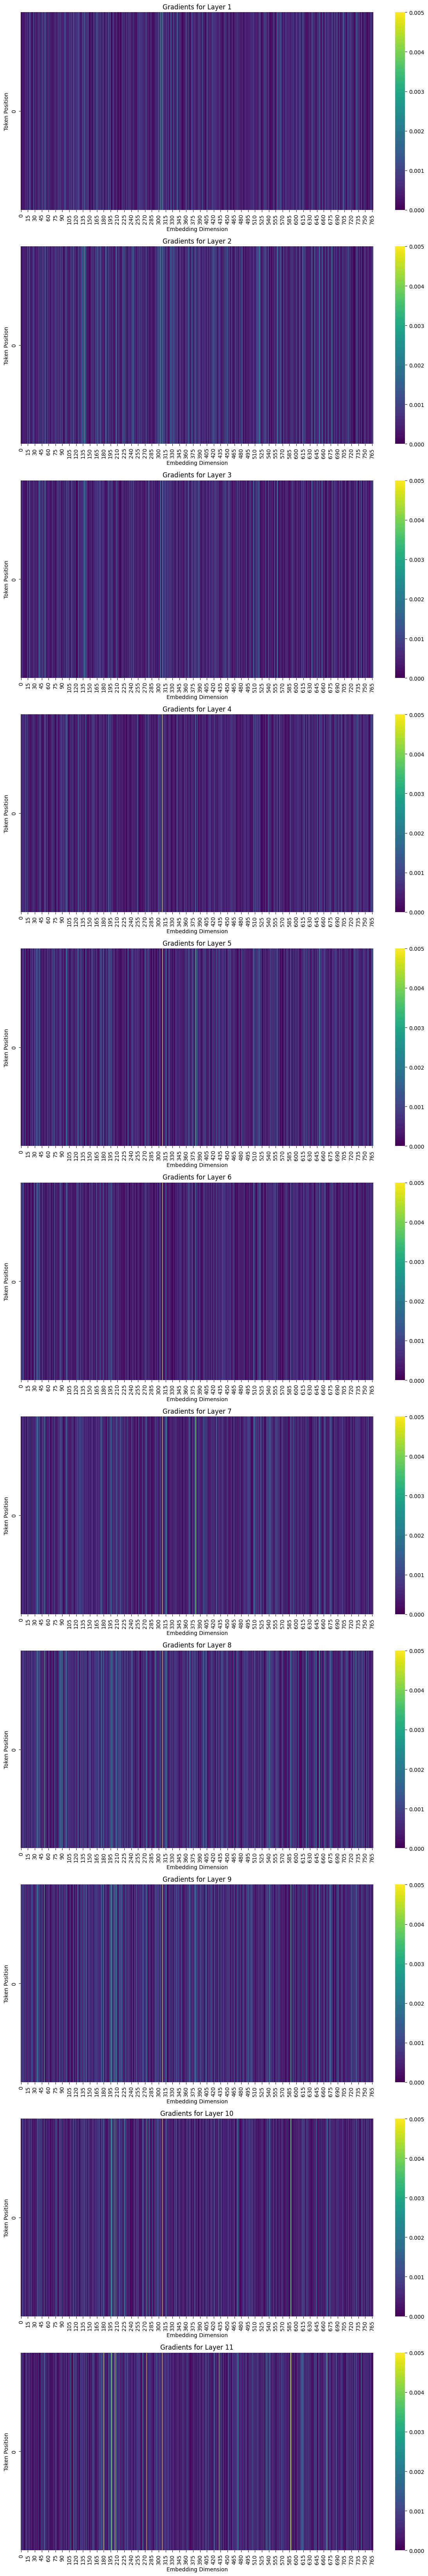

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

layers_to_visualize = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9', 'Layer 10', 'Layer 11']

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))  # Adjust size as needed

# Define the colorbar range
vmin = 0  # Minimum value of the gradient magnitude to display
vmax = 0.005  # Maximum value of the gradient magnitude to display


# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    gradient_matrix = gradients[layer]

    first_20_tokens = gradient_matrix[0:1, :] # only cls
    # Plot heatmap
    sns.heatmap(abs(first_20_tokens), ax=ax, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

# Show the plot
plt.tight_layout()
plt.show()

# plot only first 20 token postions

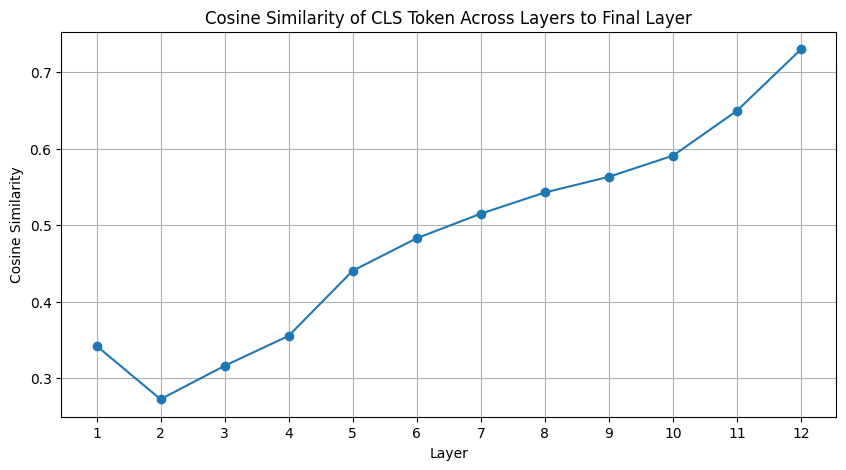

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hidden_states is obtained from the model outputs
cls_similarities = []

# Extract the CLS token from the last layer for comparison
final_cls = last_hidden_state[:, 0, :]  # Last layer, first token

for i in range(len(all_hidden_states) - 1):  # Exclude the last layer as it is used for comparison
    current_cls = all_hidden_states[i][:, 0, :]  # First token of each layer
    # Compute cosine similarity and take the mean across the batch if needed
    cosine_sim = F.cosine_similarity(current_cls, final_cls, dim=1).mean().item()
    cls_similarities.append(cosine_sim)

# Plot the cosine similarities between the CLS token of each layer and the last layer's CLS token
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(all_hidden_states)), cls_similarities, marker='o', linestyle='-')
plt.title('Cosine Similarity of CLS Token Across Layers to Final Layer')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.xticks(range(1, len(all_hidden_states)))  # Adjust the x-ticks to match layer numbers
plt.grid(True)
plt.show()


In [ ]:
# sum of cls token across embedding dimensions for loss function?
# try llama2
# if the model is trained with this data, then the gradient would go like this? how about linear layer?